**Deep Computer Vision Using Convolutional Neural Networks**

Convolutional neural networks (CNNs) emerged from the study of the brain’s visual
cortex, and they have been used in image recognition since the 1980s. In the last few
years, thanks to the increase in computational power, the amount of available training
data, and the tricks for training deep nets, CNNs have managed
to achieve superhuman performance on some complex visual tasks. They power
image search services, self-driving cars, automatic video classification systems, and
more. Moreover, CNNs are not restricted to visual perception: they are also successful
at many other tasks, such as voice recognition and natural language processing. However,
we will focus on visual applications for now.

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0-preview.

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0-preview is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

A couple utility functions to plot grayscale and RGB images:

In [ ]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

# What is a Convolution?

In TensorFlow, each input image is typically represented as a 3D tensor of shape
[height, width, channels]. A mini-batch is represented as a 4D tensor of shape [minibatch
size, height, width, channels]. The weights of a convolutional layer are represented
as a 4D tensor of shape [$f_h$, $f_w$, $f_n′$, $f_n$]. The bias terms of a convolutional layer
are simply represented as a 1D tensor of shape [$f_n$].


Let’s look at a simple example. The following code loads two sample images, using
Scikit-Learn’s load_sample_image() (which loads two color images, one of a Chinese
temple, and the other of a flower), then it creates two filters and applies them to both
images, and finally it displays one of the resulting feature maps. Note that you must
pip install the Pillow package to use load_sample_image().


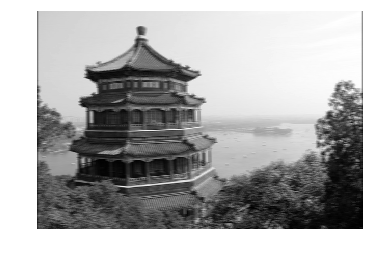

In [ ]:
import numpy as np
from sklearn.datasets import load_sample_image

# Load sample images
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

plt.imshow(outputs[0, :, :, 1], cmap="gray") # plot 1st image's 2nd feature map
plt.axis("off") # Not shown in the book
plt.show()

Let’s go through this code:
- The pixel intensity for each color channel is represented as a byte from 0 to 255, so we scale these features simply by dividing by 255, to get floats ranging from 0 to 1.
- Then we create two 7 × 7 filters (one with a vertical white line in the middle, and the other with a horizontal white line in the middle).
- We apply them to both images using the tf.nn.conv2d() function, which is part of TensorFlow’s low-level Deep Learning API. In this example, we use zero padding (padding="SAME") and a stride of 1.
- Finally, we plot one of the resulting feature maps

The tf.nn.conv2d() line deserves a bit more explanation:
- images is the input mini-batch (a 4D tensor).
- filters is the set of filters to apply (also a 4D tensor).
- strides is equal to 1, but it could also be a 1D array with four elements, where the two central elements are the vertical and horizontal strides ($s_h$ and $s_w$). The first and last elements must currently be equal to 1. They may one day be used to specify a batch stride (to skip some instances) and a channel stride (to skip some of the previous layer’s feature maps or channels).

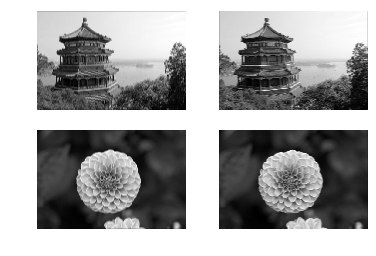

In [ ]:
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(outputs[image_index, :, :, feature_map_index])

plt.show()

In [ ]:
def crop(images):
    return images[150:220, 130:250]

Saving figure china_original


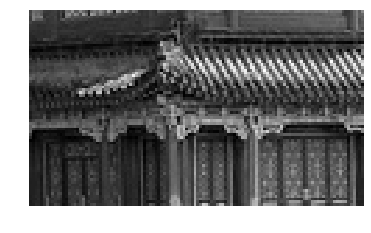

Saving figure china_vertical


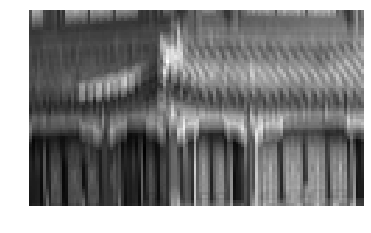

Saving figure china_horizontal


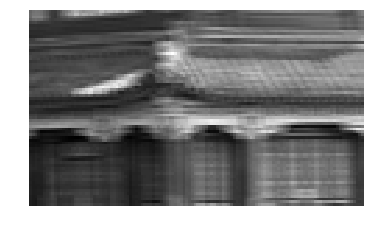

In [ ]:
plot_image(crop(images[0, :, :, 0]))
plt.show()

for feature_map_index, filename in enumerate(["china_vertical", "china_horizontal"]):
    plot_image(crop(outputs[0, :, :, feature_map_index]))
    plt.show()

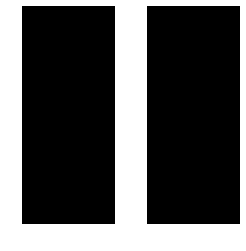

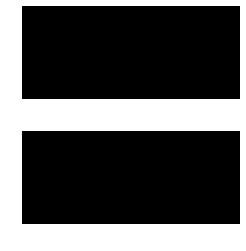

In [ ]:
plot_image(filters[:, :, 0, 0])
plt.show()
plot_image(filters[:, :, 0, 1])
plt.show()

## Convolutional Layer

Using `keras.layers.Conv2D()`:

In [ ]:
conv = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1,
                           padding="SAME", activation="relu")

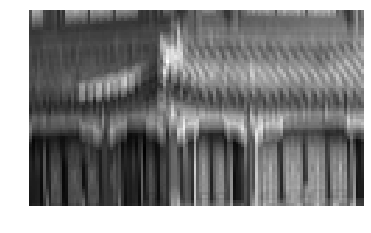

In [ ]:
plot_image(crop(outputs[0, :, :, 0]))
plt.show()

This code creates a Conv2D layer with 32 filters, each 3 × 3, using a stride of 1 (both
horizontally and vertically) and "same" padding, and applying the ReLU activation
function to its outputs. As you can see, convolutional layers have quite a few hyperparameters:
you must choose the number of filters, their height and width, the
strides, and the padding type. As always, you can use cross-validation to find the right
hyperparameter values, but this is very time-consuming. We will discuss common
CNN architectures later, to give you some idea of which hyperparameter values work
best in practice.

## VALID vs SAME padding

padding must be either "SAME" or "VALID":

—If set to "SAME", the convolutional layer uses zero padding if necessary. The
output size is set to the number of input neurons divided by the stride, rounded
up. For example, if the input size is 13 and the stride is 5,
then the output size is 3 (i.e., 13 / 5 = 2.6, rounded up to 3). Then zeros are
added as evenly as possible around the inputs, as needed. When strides=1,
the layer’s outputs will have the same spatial dimensions (width and height) as
its inputs, hence the name same.

If set to "VALID", the convolutional layer does not use zero padding and may
ignore some rows and columns at the bottom and right of the input image,
depending on the stride (for simplicity, only the horizontal
dimension is shown here, but of course the same logic applies to the
vertical dimension). This means that every neuron’s receptive field lies strictly
within valid positions inside the input (it does not go out of bounds), hence the name valid.

In [ ]:
def feature_map_size(input_size, kernel_size, strides=1, padding="SAME"):
    if padding == "SAME":
        return (input_size - 1) // strides + 1
    else:
        return (input_size - kernel_size) // strides + 1

In [ ]:
def pad_before_and_padded_size(input_size, kernel_size, strides=1):
    fmap_size = feature_map_size(input_size, kernel_size, strides)
    padded_size = max((fmap_size - 1) * strides + kernel_size, input_size)
    pad_before = (padded_size - input_size) // 2
    return pad_before, padded_size

In [ ]:
def manual_same_padding(images, kernel_size, strides=1):
    if kernel_size == 1:
        return images.astype(np.float32)
    batch_size, height, width, channels = images.shape
    top_pad, padded_height = pad_before_and_padded_size(height, kernel_size, strides)
    left_pad, padded_width  = pad_before_and_padded_size(width, kernel_size, strides)
    padded_shape = [batch_size, padded_height, padded_width, channels]
    padded_images = np.zeros(padded_shape, dtype=np.float32)
    padded_images[:, top_pad:height+top_pad, left_pad:width+left_pad, :] = images
    return padded_images

Using `"SAME"` padding is equivalent to padding manually using `manual_same_padding()` then using `"VALID"` padding (confusingly, `"VALID"` padding means no padding at all):

In [ ]:
kernel_size = 7
strides = 2

conv_valid = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding="VALID")
conv_same = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding="SAME")

valid_output = conv_valid(manual_same_padding(images, kernel_size, strides))

# Need to call build() so conv_same's weights get created
conv_same.build(tf.TensorShape(images.shape))

# Copy the weights from conv_valid to conv_same
conv_same.set_weights(conv_valid.get_weights())

same_output = conv_same(images.astype(np.float32))

assert np.allclose(valid_output.numpy(), same_output.numpy())

# Pooling layer

Once you understand how convolutional layers work, the pooling layers are quite
easy to grasp. Their goal is to subsample (i.e., shrink) the input image in order to reduce the computational load, the memory usage, and the number of parameters
(thereby limiting the risk of overfitting).

Just like in convolutional layers, each neuron in a pooling layer is connected to the
outputs of a limited number of neurons in the previous layer, located within a small
rectangular receptive field. You must define its size, the stride, and the padding type,
just like before. However, a pooling neuron has no weights; all it does is aggregate the
inputs using an aggregation function such as the max or mean.

Other than reducing computations, memory usage, and the number of parameters, a
max pooling layer also introduces some level of invariance to small translations. By inserting a max pooling layer every few layers in a
CNN, it is possible to get some level of translation invariance at a larger scale. Moreover,
max pooling offers a small amount of rotational invariance and a slight scale
invariance. Such invariance (even if it is limited) can be useful in cases where the prediction
should not depend on these details, such as in classification tasks.

## Max pooling

Implementing a max pooling layer in TensorFlow is quite easy. The following code
creates a max pooling layer using a 2 × 2 kernel. The strides default to the kernel size,
so this layer will use a stride of 2 (both horizontally and vertically). By default, it uses
"valid" padding (i.e., no padding at all):

In [ ]:
max_pool = keras.layers.MaxPool2D(pool_size=2)

In [ ]:
cropped_images = np.array([crop(image) for image in images])
output = max_pool(cropped_images)

Saving figure china_max_pooling


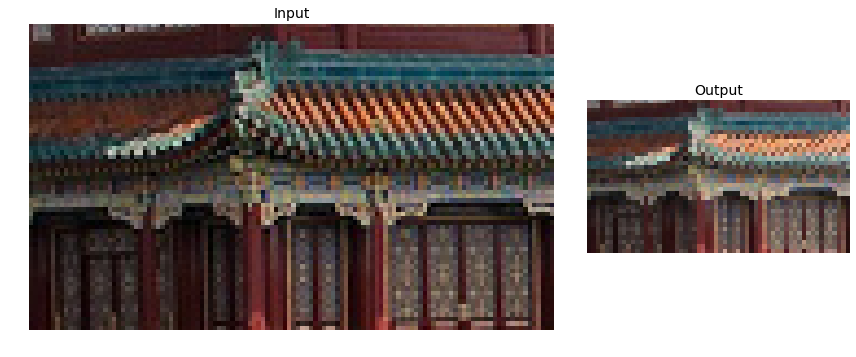

In [ ]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

## Average pooling

To create an average pooling layer, just use AvgPool2D instead of MaxPool2D. As you
might expect, it works exactly like a max pooling layer, except it computes the mean
rather than the max. Average pooling layers used to be very popular, but people
mostly use max pooling layers now, as they generally perform better. This may seem
surprising, since computing the mean generally loses less information than computing
the max. But on the other hand, max pooling preserves only the strongest features,
getting rid of all the meaningless ones, so the next layers get a cleaner signal to
work with. Moreover, max pooling offers stronger translation invariance than average
pooling, and it requires slightly less compute.

In [ ]:
avg_pool = keras.layers.AvgPool2D(pool_size=2)

In [ ]:
output_avg = avg_pool(cropped_images)

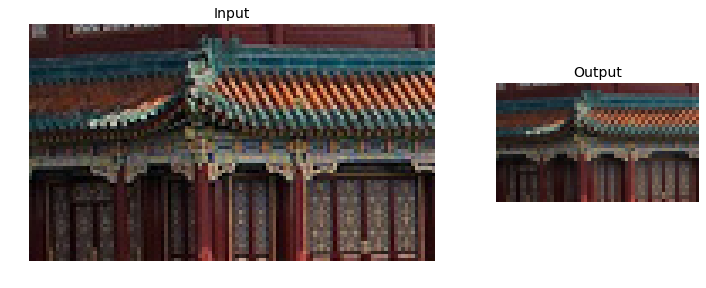

In [ ]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output_avg[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

## Global Average Pooling

One last type of pooling layer that you will often see in modern architectures is the
global average pooling layer. It works very differently: all it does is compute the mean
of each entire feature map (it’s like an average pooling layer using a pooling kernel
with the same spatial dimensions as the inputs). This means that it just outputs a single
number per feature map and per instance. Although this is of course extremely
destructive (most of the information in the feature map is lost), it can be useful as the
output layer, as we will see later in this chapter. To create such a layer, simply use the
keras.layers.GlobalAvgPool2D class:

In [ ]:
global_avg_pool = keras.layers.GlobalAvgPool2D()
global_avg_pool(cropped_images)

<tf.Tensor: id=151, shape=(2, 3), dtype=float64, numpy=
array([[0.27887768, 0.2250719 , 0.20967274],
       [0.51288515, 0.45951634, 0.33423483]])>

It’s equivalent to this simple Lambda layer, which computes the mean over the spatial
dimensions (height and width):

In [ ]:
output_global_avg2 = keras.layers.Lambda(lambda X: tf.reduce_mean(X, axis=[1, 2]))
output_global_avg2(cropped_images)

<tf.Tensor: id=155, shape=(2, 3), dtype=float64, numpy=
array([[0.27887768, 0.2250719 , 0.20967274],
       [0.51288515, 0.45951634, 0.33423483]])>

# Tackling Fashion MNIST With a CNN

Here is how you can implement a simple CNN to tackle the Fashion MNIST dataset

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [ ]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3), activation='relu', padding="VALID")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])

Let’s go through this model:
- The first layer uses 64 fairly large filters (7 × 7) but no stride because the input images are not very large. It also sets input_shape=[28, 28, 1], because the images are 28 × 28 pixels, with a single color channel (i.e., grayscale).
- Next we have a max pooling layer which uses a pool size of 2, so it divides each spatial dimension by a factor of 2.
- Then we repeat the same structure twice: two convolutional layers followed by a max pooling layer. For larger images, we could repeat this structure several more times (the number of repetitions is a hyperparameter you can tune).
- Note that the number of filters grows as we climb up the CNN toward the output layer (it is initially 64, then 128, then 256): it makes sense for it to grow, since the number of low-level features is often fairly low (e.g., small circles, horizontal ines), but there are many different ways to combine them into higher-level features. t is a common practice to double the number of filters after each pooling ayer: since a pooling layer divides each spatial dimension by a factor of 2, we can fford to double the number of feature maps in the next layer without fear of xploding the number of parameters, memory usage, or computational load.
- Next is the fully connected network, composed of two hidden dense layers and a ense output layer. Note that we must flatten its inputs, since a dense network xpects a 1D array of features for each instance. We also add two dropout layers, ith a dropout rate of 50% each, to reduce overfitting.

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=[X_valid, y_valid])
score = model.evaluate(X_test, y_test)
X_new = X_test[:10] # pretend we have new images
y_pred = model.predict(X_new)

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 51s 923us/sample - loss: 0.7183 - accuracy: 0.7529 - val_loss: 0.4029 - val_accuracy: 0.8510
Epoch 2/10
55000/55000 [==============================] - 47s 863us/sample - loss: 0.4185 - accuracy: 0.8592 - val_loss: 0.3285 - val_accuracy: 0.8854
Epoch 3/10
55000/55000 [==============================] - 46s 836us/sample - loss: 0.3691 - accuracy: 0.8765 - val_loss: 0.2905 - val_accuracy: 0.8936
Epoch 4/10
55000/55000 [==============================] - 46s 832us/sample - loss: 0.3324 - accuracy: 0.8879 - val_loss: 0.2794 - val_accuracy: 0.8970
Epoch 5/10
55000/55000 [==============================] - 48s 880us/sample - loss: 0.3100 - accuracy: 0.8960 - val_loss: 0.2872 - val_accuracy: 0.8942
Epoch 6/10
55000/55000 [==============================] - 51s 921us/sample - loss: 0.2930 - accuracy: 0.9008 - val_loss: 0.2863 - val_accuracy: 0.8980
Epoch 7/10
55000/55000 [=====================

## LeNet-5

The LeNet-5 architecture10 is perhaps the most widely known CNN architecture. As
mentioned earlier, it was created by Yann LeCun in 1998 and has been widely used
for handwritten digit recognition (MNIST).

In [ ]:
from keras import layers
from keras.models import Model

def lenet_5(in_shape=(32,32,1), n_classes=10, opt='sgd'):
    in_layer = layers.Input(in_shape)
    conv1 = layers.Conv2D(filters=20, kernel_size=5,
                          padding='same', activation='relu')(in_layer)
    pool1 = layers.AvgPool2D()(conv1)
    conv2 = layers.Conv2D(filters=50, kernel_size=5,
                          padding='same', activation='relu')(pool1)
    pool2 = layers.AvgPool2D()(conv2)
    flatten = layers.Flatten()(pool2)
    dense1 = layers.Dense(84, activation='relu')(flatten)
    preds = layers.Dense(n_classes, activation='softmax')(dense1)

    model = Model(in_layer, preds)
    model.compile(loss="categorical_crossentropy", optimizer=opt,
                  metrics=["accuracy"])
    return model

if __name__ == '__main__':
    model = lenet_5()
    print(model.summary())

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 20)        520       
_________________________________________________________________
average_pooling2d_1 (Average (None, 16, 16, 20)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 50)        25050     
_________________________________________________________________
average_pooling2d_2 (Average (None, 8, 8, 50)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 84)                2688

There are a few extra details to be noted:
- MNIST images are 28 × 28 pixels, but they are zero-padded to 32 × 32 pixels and normalized before being fed to the network. The rest of the network does not use any padding, which is why the size keeps shrinking as the image progresses through the network.
- The average pooling layers are slightly more complex than usual: each neuron computes the mean of its inputs, then multiplies the result by a learnable coefficient (one per map) and adds a learnable bias term (again, one per map), then finally applies the activation function.
- Most neurons in C3 maps are connected to neurons in only three or four S2 maps (instead of all six S2 maps).
- The output layer is a bit special: instead of computing the matrix multiplication of the inputs and the weight vector, each neuron outputs the square of the Euclidian distance between its input vector and its weight vector. Each output measures how much the image belongs to a particular digit class. The cross-entropy cost function is now preferred, as it penalizes bad predictions much more, producing larger gradients and converging faster.

## AlexNet

It is similar to LeNet-5, only much larger and deeper, and it was the
first to stack convolutional layers directly on top of one another, instead of stacking a
pooling layer on top of each convolutional layer

In [ ]:
from keras import layers
from keras.models import Model

def alexnet(in_shape=(227,227,3), n_classes=1000, opt='sgd'):
    in_layer = layers.Input(in_shape)
    conv1 = layers.Conv2D(96, 11, strides=4, activation='relu')(in_layer)
    pool1 = layers.MaxPool2D(3, 2)(conv1)
    conv2 = layers.Conv2D(256, 5, strides=1, padding='same', activation='relu')(pool1)
    pool2 = layers.MaxPool2D(3, 2)(conv2)
    conv3 = layers.Conv2D(384, 3, strides=1, padding='same', activation='relu')(pool2)
    conv4 = layers.Conv2D(256, 3, strides=1, padding='same', activation='relu')(conv3)
    pool3 = layers.MaxPool2D(3, 2)(conv4)
    flattened = layers.Flatten()(pool3)
    dense1 = layers.Dense(4096, activation='relu')(flattened)
    drop1 = layers.Dropout(0.5)(dense1)
    dense2 = layers.Dense(4096, activation='relu')(drop1)
    drop2 = layers.Dropout(0.5)(dense2)
    preds = layers.Dense(n_classes, activation='softmax')(drop2)

    model = Model(in_layer, preds)
    model.compile(loss="categorical_crossentropy", optimizer=opt,
                  metrics=["accuracy"])
    return model

if __name__ == '__main__':
    model = alexnet()
    print(model.summary())

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 227, 227, 3)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 55, 55, 96)        34944     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 27, 27, 256)       614656    
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 13, 13, 256)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 13, 13, 384)       885120    
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 13, 13, 256)       8849

## VGGNet

Visual Geometry Group (VGG) research lab at Oxford University proposed VGGNet. It had a very simple and classical architecture, with 2 or 3
convolutional layers and a pooling layer, then again 2 or 3 convolutional layers and a
pooling layer, and so on (reaching a total of just 16 or 19 convolutional layers,
depending on the VGG variant), plus a final dense network with 2 hidden layers and
the output layer. It used only 3 × 3 filters, but many filters.

In [ ]:
from keras import layers
from keras.models import Model, Sequential

from functools import partial

conv3 = partial(layers.Conv2D,
                kernel_size=3,
                strides=1,
                padding='same',
                activation='relu')

def block(in_tensor, filters, n_convs):
    conv_block = in_tensor
    for _ in range(n_convs):
        conv_block = conv3(filters=filters)(conv_block)
    return conv_block

def _vgg(in_shape=(227,227,3),
         n_classes=1000,
         opt='sgd',
         n_stages_per_blocks=[2, 2, 3, 3, 3]):
    in_layer = layers.Input(in_shape)

    block1 = block(in_layer, 64, n_stages_per_blocks[0])
    pool1 = layers.MaxPool2D()(block1)
    block2 = block(pool1, 128, n_stages_per_blocks[1])
    pool2 = layers.MaxPool2D()(block2)
    block3 = block(pool2, 256, n_stages_per_blocks[2])
    pool3 = layers.MaxPool2D()(block3)
    block4 = block(pool3, 512, n_stages_per_blocks[3])
    pool4 = layers.MaxPool2D()(block4)
    block5 = block(pool4, 512, n_stages_per_blocks[4])
    pool5 = layers.MaxPool2D()(block5)
    flattened = layers.GlobalAvgPool2D()(pool5)

    dense1 = layers.Dense(4096, activation='relu')(flattened)
    dense2 = layers.Dense(4096, activation='relu')(dense1)
    preds = layers.Dense(1000, activation='softmax')(dense2)

    model = Model(in_layer, preds)
    model.compile(loss="categorical_crossentropy", optimizer=opt,
              metrics=["accuracy"])
    return model

def vgg16(in_shape=(227,227,3), n_classes=1000, opt='sgd'):
    return _vgg(in_shape, n_classes, opt)

def vgg19(in_shape=(227,227,3), n_classes=1000, opt='sgd'):
    return _vgg(in_shape, n_classes, opt, [2, 2, 4, 4, 4])

if __name__ == '__main__':
    model = vgg19()
    print(model.summary())

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 227, 227, 3)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 227, 227, 64)      1792      
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 227, 227, 64)      36928     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 113, 113, 64)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 113, 113, 128)     73856     
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 113, 113, 128)     147584    
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 56, 56, 128)       0   

## GoogLeNet

GoogLeNet adopted subnetworks called inception modules, to use
parameters much more efficiently than previous architectures: GoogLeNet actually
has 10 times fewer parameters than AlexNet

Reasons for using these inception modules:
1. Each layer type extracts different information from input. Information gathered from a 3×3 layer will differ from information gathered from a 5×5 layer. How do we know which transformation will be the best at a given layer? So we use them all!
2. Dimensionality reduction using 1×1 convolutions! Consider a 128x128x256 input. If we pass it through 20 filters of size 1×1, we will get an output of 128x128x20. So we apply them before the 3×3 or 5×5 convolutions to decrease the number of input filters to these layers in the inception block used for dimensionality reduction.

In [ ]:
from keras import layers
from keras.models import Model

from functools import partial

conv1x1 = partial(layers.Conv2D, kernel_size=1, activation='relu')
conv3x3 = partial(layers.Conv2D, kernel_size=3, padding='same', activation='relu')
conv5x5 = partial(layers.Conv2D, kernel_size=5, padding='same', activation='relu')

def inception_module(in_tensor, c1, c3_1, c3, c5_1, c5, pp):
    conv1 = conv1x1(c1)(in_tensor)

    conv3_1 = conv1x1(c3_1)(in_tensor)
    conv3 = conv3x3(c3)(conv3_1)

    conv5_1 = conv1x1(c5_1)(in_tensor)
    conv5 = conv5x5(c5)(conv5_1)

    pool_conv = conv1x1(pp)(in_tensor)
    pool = layers.MaxPool2D(3, strides=1, padding='same')(pool_conv)

    merged = layers.Concatenate(axis=-1)([conv1, conv3, conv5, pool])
    return merged

def aux_clf(in_tensor):
    avg_pool = layers.AvgPool2D(5, 3)(in_tensor)
    conv = conv1x1(128)(avg_pool)
    flattened = layers.Flatten()(conv)
    dense = layers.Dense(1024, activation='relu')(flattened)
    dropout = layers.Dropout(0.7)(dense)
    out = layers.Dense(1000, activation='softmax')(dropout)
    return out

def inception_net(in_shape=(224,224,3), n_classes=1000, opt='sgd'):
    in_layer = layers.Input(in_shape)

    conv1 = layers.Conv2D(64, 7, strides=2, activation='relu', padding='same')(in_layer)
    pad1 = layers.ZeroPadding2D()(conv1)
    pool1 = layers.MaxPool2D(3, 2)(pad1)
    conv2_1 = conv1x1(64)(pool1)
    conv2_2 = conv3x3(192)(conv2_1)
    pad2 = layers.ZeroPadding2D()(conv2_2)
    pool2 = layers.MaxPool2D(3, 2)(pad2)

    inception3a = inception_module(pool2, 64, 96, 128, 16, 32, 32)
    inception3b = inception_module(inception3a, 128, 128, 192, 32, 96, 64)
    pad3 = layers.ZeroPadding2D()(inception3b)
    pool3 = layers.MaxPool2D(3, 2)(pad3)

    inception4a = inception_module(pool3, 192, 96, 208, 16, 48, 64)
    inception4b = inception_module(inception4a, 160, 112, 224, 24, 64, 64)
    inception4c = inception_module(inception4b, 128, 128, 256, 24, 64, 64)
    inception4d = inception_module(inception4c, 112, 144, 288, 32, 48, 64)
    inception4e = inception_module(inception4d, 256, 160, 320, 32, 128, 128)
    pad4 = layers.ZeroPadding2D()(inception4e)
    pool4 = layers.MaxPool2D(3, 2)(pad4)

    aux_clf1 = aux_clf(inception4a)
    aux_clf2 = aux_clf(inception4d)

    inception5a = inception_module(pool4, 256, 160, 320, 32, 128, 128)
    inception5b = inception_module(inception5a, 384, 192, 384, 48, 128, 128)
    pad5 = layers.ZeroPadding2D()(inception5b)
    pool5 = layers.MaxPool2D(3, 2)(pad5)

    avg_pool = layers.GlobalAvgPool2D()(pool5)
    dropout = layers.Dropout(0.4)(avg_pool)
    preds = layers.Dense(1000, activation='softmax')(dropout)

    model = Model(in_layer, [preds, aux_clf1, aux_clf2])
    model.compile(loss="categorical_crossentropy", optimizer=opt,
              metrics=["accuracy"])
    return model

if __name__ == '__main__':
    model = inception_net()
    print(model.summary())

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, 112, 112, 64) 9472        input_8[0][0]                    
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 114, 114, 64) 0           conv2d_31[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_17 (MaxPooling2D) (None, 56, 56, 64)   0           zero_padding2d_1[0][0]           
____________________________________________________________________________________________

## ResNet

Residual Network (or ResNet) used an extremely deep CNN composed of 152 layers (other variants had 34,
50, and 101 layers). It confirmed the general trend: models are getting deeper and
deeper, with fewer and fewer parameters. The key to being able to train such a deep
network is to use skip connections (also called shortcut connections): the signal feeding
into a layer is also added to the output of a layer located a bit higher up the stack.

When training a neural network, the goal is to make it model a target function h(x).
If you add the input x to the output of the network (i.e., you add a skip connection),
then the network will be forced to model f(x) = h(x) – x rather than h(x). This is
called residual learning.

When you initialize a regular neural network, its weights are close to zero, so the network
just outputs values close to zero. If you add a skip connection, the resulting network
just outputs a copy of its inputs; in other words, it initially models the identity
function. If the target function is fairly close to the identity function (which is often
the case), this will speed up training considerably.

Moreover, if you add many skip connections, the network can start making progress
even if several layers have not started learning yet. Thanks to skip
connections, the signal can easily make its way across the whole network. The deep
residual network can be seen as a stack of residual units (RUs), where each residual
unit is a small neural network with a skip connection.

ResNet starts and ends exactly like GoogLeNet (except without a dropout layer), and in
between is just a very deep stack of simple residual units. Each residual unit is composed
of two convolutional layers (and no pooling layer!), with Batch Normalization
(BN) and ReLU activation, using 3 × 3 kernels and preserving spatial dimensions
(stride 1, "same" padding).

## ResNet-34

Most CNN architectures described so far are fairly straightforward to implement
(although generally you would load a pretrained network instead, as we will see). To
illustrate the process, let’s implement a ResNet-34 from scratch using Keras. First, let’s
create a ResidualUnit layer:

In [ ]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

As you can see, in the constructor, we
create all the layers we will need. Then in the call() method, we make the inputs go through the main
layers and the skip layers (if any), then we add both outputs and apply the activation
function.

Next, we can build the ResNet-34 using a Sequential model, since it’s really just a
long sequence of layers (we can treat each residual unit as a single layer now that we
have the ResidualUnit class：

In [ ]:
model = keras.models.Sequential()
model.add(DefaultConv2D(64, kernel_size=7, strides=2,
                        input_shape=[224, 224, 3]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

The only slightly tricky part in this code is the loop that adds the ResidualUnit layers
to the model: as explained earlier, the first 3 RUs have 64 filters, then the next 4 RUs
have 128 filters, and so on. We then set the stride to 1 when the number of filters is
the same as in the previous RU, or else we set it to 2. Then we add the ResidualUnit,
and finally we update prev_filters.

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 112, 112, 64)      9408      
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 56, 64)        0         
_________________________________________________________________
residual_unit (ResidualUnit) (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_1 (ResidualUni (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_2 (ResidualUni (None, 56, 56, 64)        7

## Using a Pretrained Model

In general, you won’t have to implement standard models like GoogLeNet or ResNet
manually, since pretrained networks are readily available with a single line of code in
the keras.applications package. For example, you can load the ResNet-50 model,
pretrained on ImageNet, with the following line of code:

In [ ]:
model = keras.applications.resnet50.ResNet50(weights="imagenet")

That’s all! This will create a ResNet-50 model and download weights pretrained on
the ImageNet dataset. To use it, you first need to ensure that the images have the right
size. A ResNet-50 model expects 224 × 224-pixel images (other models may expect
other sizes, such as 299 × 299), so let’s use TensorFlow’s tf.image.resize() function
to resize the images we loaded earlier:

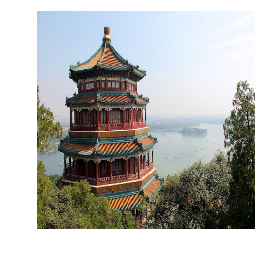

In [ ]:
images_resized = tf.image.resize(images, [224, 224])
plot_color_image(images_resized[0])
plt.show()

W0323 19:04:32.720291 140735783818112 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


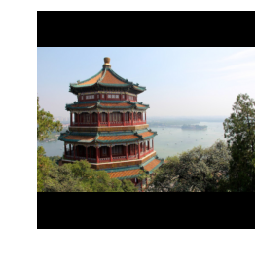

In [ ]:
images_resized = tf.image.resize_with_pad(images, 224, 224, antialias=True)
plot_color_image(images_resized[0])

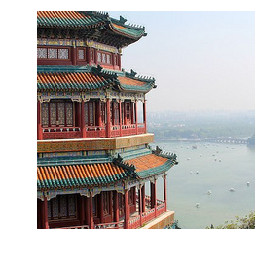

In [ ]:
images_resized = tf.image.resize_with_crop_or_pad(images, 224, 224)
plot_color_image(images_resized[0])
plt.show()

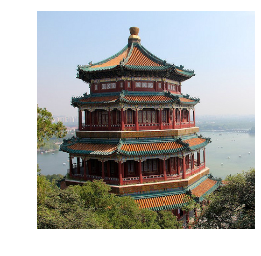

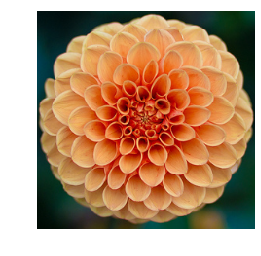

In [ ]:
china_box = [0, 0.03, 1, 0.68]
flower_box = [0.19, 0.26, 0.86, 0.7]
images_resized = tf.image.crop_and_resize(images, [china_box, flower_box], [0, 1], [224, 224])
plot_color_image(images_resized[0])
plt.show()
plot_color_image(images_resized[1])
plt.show()

The pretrained models assume that the images are preprocessed in a specific way. In
some cases they may expect the inputs to be scaled from 0 to 1, or –1 to 1, and so on.
Each model provides a preprocess_input() function that you can use to preprocess
your images. These functions assume that the pixel values range from 0 to 255, so we
must multiply them by 255 (since earlier we scaled them to the 0–1 range):

In [ ]:
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)
Y_proba = model.predict(inputs)

Now we can use the pretrained model to make predictions:

In [ ]:
Y_proba.shape

(2, 1000)

As usual, the output Y_proba is a matrix with one row per image and one column per
class (in this case, there are 1,000 classes). If you want to display the top K predictions,
including the class name and the estimated probability of each predicted class,
use the decode_predictions() function. For each image, it returns an array containing
the top K predictions, where each prediction is represented as an array containing
the class identifier, its name, and the corresponding confidence score:

In [ ]:
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print("Image #{}".format(image_index))
    for class_id, name, y_proba in top_K[image_index]:
        print("  {} - {:12s} {:.2f}%".format(class_id, name, y_proba * 100))
    print()

Image #0
  n03877845 - palace       42.87%
  n02825657 - bell_cote    40.57%
  n03781244 - monastery    14.56%

Image #1
  n04522168 - vase         46.83%
  n07930864 - cup          7.78%
  n11939491 - daisy        4.87%



The correct classes (monastery and daisy) appear in the top three results for both
images. That’s pretty good, considering that the model had to choose from among
1,000 classes.

As you can see, it is very easy to create a pretty good image classifier using a pretrained
model. Other vision models are available in keras.applications, including
several ResNet variants, GoogLeNet variants like Inception-v3 and Xception,
VGGNet variants, and MobileNet and MobileNetV2 (lightweight models for use in
mobile applications).

But what if you want to use an image classifier for classes of images that are not part
of ImageNet? In that case, you may still benefit from the pretrained models to perform
transfer learning.

## Pretrained Models for Transfer Learning

If you want to build an image classifier but you do not have enough training data,
then it is often a good idea to reuse the lower layers of a pretrained model. For example, let’s train a model to classify pictures of flowers,
reusing a pretrained Xception model. First, let’s load the dataset using TensorFlow Datasets:

In [ ]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)

In [ ]:
info.splits

{'train': <tfds.core.SplitInfo num_examples=3670>}

In [ ]:
info.splits["train"]

<tfds.core.SplitInfo num_examples=3670>

In [ ]:
class_names = info.features["label"].names
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [ ]:
n_classes = info.features["label"].num_classes

In [ ]:
dataset_size = info.splits["train"].num_examples
dataset_size

3670

Note that you can get information about the dataset by setting with_info=True. Here,
we get the dataset size and the names of the classes. Unfortunately, there is only a
"train" dataset, no test set or validation set, so we need to split the training set. The
TF Datasets project provides an API for this. For example, let’s take the first 10% of
the dataset for testing, the next 15% for validation, and the remaining 75% for
training:

In [ ]:
test_split, valid_split, train_split = tfds.Split.TRAIN.subsplit([10, 15, 75])

test_set_raw = tfds.load("tf_flowers", split=test_split, as_supervised=True)
valid_set_raw = tfds.load("tf_flowers", split=valid_split, as_supervised=True)
train_set_raw = tfds.load("tf_flowers", split=train_split, as_supervised=True)

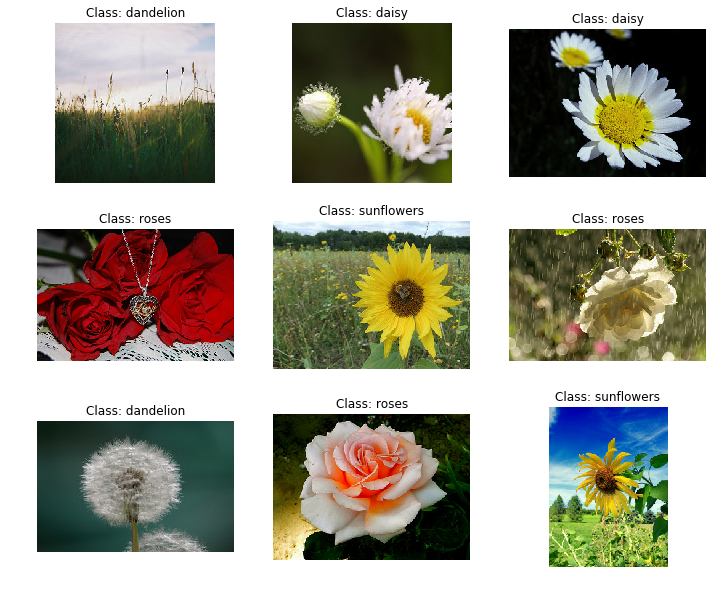

In [ ]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

Next we must preprocess the images. The CNN expects 224 × 224 images, so we need
to resize them. We also need to run the images through Xception’s prepro
cess_input() function:

In [ ]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

Slightly fancier preprocessing (but you could add much more data augmentation):

In [ ]:
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

If you want to perform some data augmentation, change the preprocessing function
for the training set, adding some random transformations to the training images. For
example, use tf.image.random_crop() to randomly crop the images, use
tf.image.random_flip_left_right() to randomly flip the images horizontally, and
so on

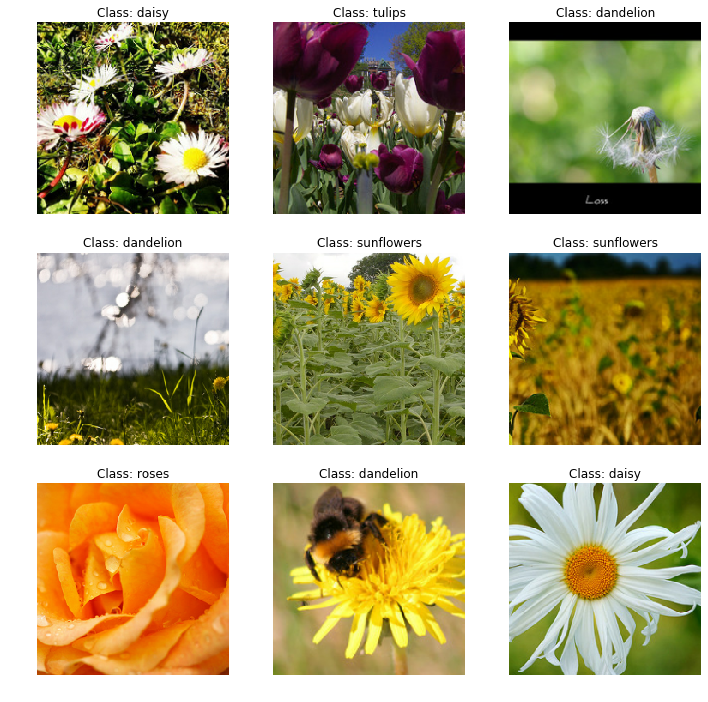

In [ ]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

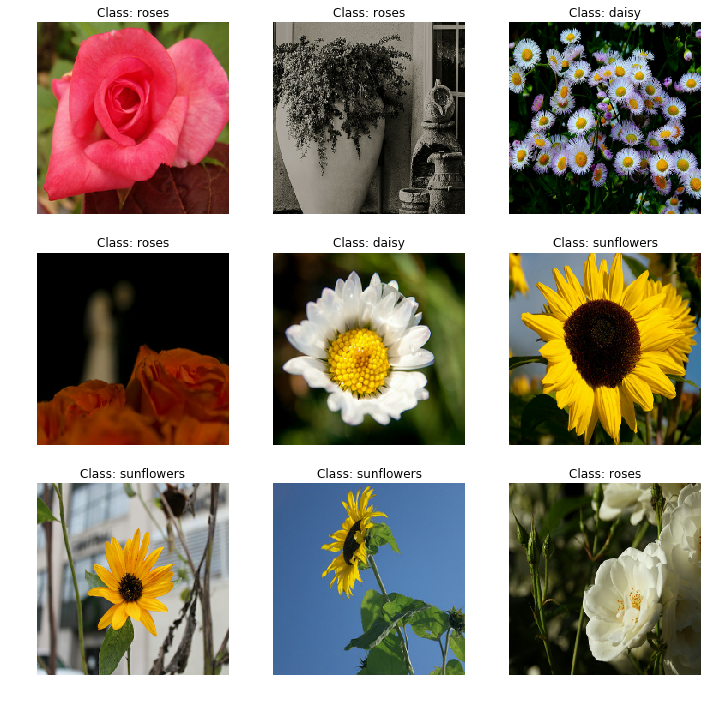

In [ ]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in test_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

Next let’s load an Xception model, pretrained on ImageNet. We exclude the top of the
network by setting include_top=False: this excludes the global average pooling layer
and the dense output layer. We then add our own global average pooling layer, based
on the output of the base model, followed by a dense output layer with one unit per
class, using the softmax activation function. Finally, we create the Keras Model:

In [ ]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

In [ ]:
for index, layer in enumerate(base_model.layers):
    print(index, layer.name)

0 input_2
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_44
13 block2_pool
14 batch_normalization_35
15 add_16
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_45
23 block3_pool
24 batch_normalization_36
25 add_17
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_46
33 block4_pool
34 batch_normalization_37
<<62 more lines>>
97 block11_sepconv1
98 block11_sepconv1_bn
99 block11_sepconv2_act
100 block11_sepconv2
101 block11_sepconv2_bn
102 block11_sepconv3_act
103 block11_sepconv3
104 block11_sepconv3_bn
105 add_25
106 block12_sepconv1_act
107 block12_sepconv1
108 block12_sepconv1_bn
109 block12_sepconv2_act
110 block12_sepconv2
111 block12_sepconv

It’s usually a good idea to freeze the weights of the pretrained
layers, at least at the beginning of training:

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)

Epoch 1/5
86/86 [==============================] - 46s 532ms/step - loss: 0.6858 - accuracy: 0.7758 - val_loss: 1.7375 - val_accuracy: 0.7335
Epoch 2/5
86/86 [==============================] - 39s 450ms/step - loss: 0.3833 - accuracy: 0.8765 - val_loss: 1.2491 - val_accuracy: 0.7592
Epoch 3/5
86/86 [==============================] - 39s 450ms/step - loss: 0.3270 - accuracy: 0.8903 - val_loss: 1.2740 - val_accuracy: 0.7647
Epoch 4/5
86/86 [==============================] - 39s 451ms/step - loss: 0.2821 - accuracy: 0.9113 - val_loss: 1.1322 - val_accuracy: 0.7757
Epoch 5/5
86/86 [==============================] - 39s 452ms/step - loss: 0.2430 - accuracy: 0.9121 - val_loss: 1.5182 - val_accuracy: 0.7426


After training the model for a few epochs, its validation accuracy should reach about
75% and stop making much progress. This means that the top layers are now
pretty well trained, so we are ready to unfreeze all the layers (or you could try
unfreezing just the top ones) and continue training (don’t forget to compile the
model when you freeze or unfreeze layers). This time we use a much lower learning
rate to avoid damaging the pretrained weights:

In [ ]:
for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=40)

Epoch 1/40
86/86 [==============================] - 172s 2s/step - loss: 0.2257 - accuracy: 0.9288 - val_loss: 0.6762 - val_accuracy: 0.8346
Epoch 2/40
86/86 [==============================] - 128s 1s/step - loss: 0.1124 - accuracy: 0.9640 - val_loss: 0.3932 - val_accuracy: 0.9154
Epoch 3/40
86/86 [==============================] - 129s 1s/step - loss: 0.0497 - accuracy: 0.9829 - val_loss: 0.2618 - val_accuracy: 0.9246
Epoch 4/40
86/86 [==============================] - 128s 1s/step - loss: 0.0425 - accuracy: 0.9836 - val_loss: 0.3446 - val_accuracy: 0.9136
Epoch 5/40
86/86 [==============================] - 128s 1s/step - loss: 0.0251 - accuracy: 0.9909 - val_loss: 0.2486 - val_accuracy: 0.9338
Epoch 6/40
86/86 [==============================] - 127s 1s/step - loss: 0.0142 - accuracy: 0.9949 - val_loss: 0.2324 - val_accuracy: 0.9430
Epoch 7/40
86/86 [==============================] - 128s 1s/step - loss: 0.0195 - accuracy: 0.9945 - val_loss: 0.2785 - val_accuracy: 0.9357
Epoch 8/40
86